# AI for Earth System Science Hackathon 2020

# GECKO-A Emulation

David John Gagne, Siyuan Wang, Charlie Becker, Keely Lawrence, Alma Hodzic, Natasha Flyer

## Introduction

![GECKO](gecko_image.png)

Natural and anthropogenic sources emit a large number of volatile organic compounds (VOCs). These compounds greatly affect the “self-cleaning capacity” of the atmosphere. These compounds can also undergo complicated chemical and physical processes in the atmosphere, forming organic aerosols. Organic aerosols have significant direct (absorbing/scattering) and indirect (affect cloud formation/properties) radiation effect.

In order to understand the broad impacts of VOCs on air quality and climate, we need to understand their sources and fates in the atmosphere. Many of these compounds can be directly emitted, or be produced from other compounds; in the meantime, they can undergo a variety of chemical reactions in the atmosphere. The chemical mechanism of these VOCs in the atmosphere can be very highly complicated, especially involving the formation of organic aerosols.

Most air quality models or chemistry-climate models are equipped with chemical mechanisms consisting of hundreds-thousands of chemical reactions. It is often found that such simplified chemical mechanisms are incapable to describe the complexity in the atmosphere. A widely used “near-explicit” chemical mechanism (Master Chemical Mechanism) consists of tens of thousands of chemical reactions, which still cannot capture the behavior and characteristics of the formation of organic aerosols. Such “near-explicit” mechanism is too computationally demanding for most air quality models or chemistry-climate models already.

NCAR (USA) and Centre National de la Recherche Scientifique (CNRS, France) jointly developed a hyper-explicit chemical mechanism: Generator of Explicit Chemistry and Kinetics of Organics in the Atmosphere (GECKO-A). GECKO-A can generate chemical mechanisms based on how the molecules/bonds/atoms interact with each other. Chemical mechanisms generated by GECKO-A usually include millions to tens of millions of reactions. Due to the remarkable computational cost, no air quality models or chemistry-climate models can afford to run with GECKO-A in the foreseeable future. There is a growing interest in the community to implement such complicated mechanisms into air quality models or chemistry-climate models, to study the broader impacts on air quality, human health, and the climate system.

Machine‐learning and artificial intelligence have proven to be a valuable tool in atmospheric science. Recent years have seen quite a few inspiring applications in developing machine-learning emulators using explicit/process-level models and implementing the trained emulators into large-scale models. Such explicit/process-level models are otherwise too expensive for large-scale models.

The goal of this project is to train the machine-learning emulator using the “library” generated by the hyper-explicit chemical mechanism, GECKO-A.

## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* tqdm

In [1]:
! pip install numpy scipy matplotlib xarray pandas netcdf4 tqdm tensorflow scikit-learn seaborn

In [2]:
pip install --upgrade pandas

Requirement already up-to-date: pandas in /opt/conda/lib/python3.7/site-packages (1.0.5)
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [4]:
import s3fs
import seaborn as sns
import pandas as pd
import pyarrow
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join, exists
from matplotlib.colors import LogNorm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import GroupKFold
from tensorflow.keras.optimizers import Adam
%matplotlib inline

seed = 8886
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

## Data

**Data generation procedure**: The machine-learning training dataset in this project (or library) is generated by the hyper-explicit chemical mechanism, GECKO-A. This library consists of results from thousands of GECKO-A simulations under vastly different conditions. More information about GECKO-A can be found [here](https://www2.acom.ucar.edu/modeling/gecko). Each model run lasts 5 simulation days.
 
### Potential Input Variables
 
* Temperature (K): The temperature at which the GECKO-A experiments were conducted. Temperature will affect the reaction rates of many reactions. It also affects the partitioning of a given compound between the gas-phase and particle-phase.
* Solar zenith angle (degree): The solar zenith angle at which the GECKO-A experiments were conducted. This will affect the photolysis reactions. 
* Pre-existing aerosols (micrograms per cubic meter): Depending on the environmental conditions (e.g., temperature) and the vapor pressure, a compound can deposit onto (pre-existing) aerosols or evaporate from the aerosols. 
* NOx (ppb): concentration of nitrogen oxides. These are important compounds in the atmosphere, affecting the chemical mechanisms of many volatile organic compounds.
* O3 (ppb): concentration of ozone. It’s another important compounds in the atmosphere, affecting the chemical mechanisms of many VOCs.
* OH (10^6 molecules per cubic centimeter): concentration of hydroxyl radicals (OH). It’s one of the most important oxidants in the atmosphere, largely driving the oxidation of many VOCs.

### Output Variables

* Precursor (micrograms per cubic meter): time series of the VOC precursor. We call it “precursor” because it’ll undergo chemical reactions and produce other compounds.
* Gas (micrograms per cubic meter): mass concentration of products in the gas-phase.
* Aerosol (micrograms per cubic meter): mass concentration of products in the aerosol-phase.

### Metadata

| Metadata | Units | Label | 
| ------------- | :----:|:----------- | 
| Number Experiments   | 2000     | id | 
| Total Timesteps   | 1440     | Time |
| Timestep Delta   | 300 seconds | - |


### Potential Input Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor  | ug/m3     | Varies | 
| Gas   | ug/m3     | Varies   |
| Aerosol   | ug/m3     | Varies |
| Temperature   | K     | Static         |
| Solar Zenith Angle   | degree     | Static        |
| Pre-existing Aersols   | ug/m3     | Static         |
| o3  | ppb     | Static         |
| nox   | ppb     | Static         |
| oh   | 10^6 molec/cm3     | Static         |

### Potential Output Variables

| Variable Name | Units | Type | 
| ------------- | :----:|:----------- | 
| Precursor (at t+1) | ug/m3     | Varies | 
| Gas   (at t+1)  | ug/m3   | Varies   |
| Aerosol (at t+1)  | ug/m3     | Varies |

### Training, validation, and testing sets

This training dataset/library consists of 2000 GECKO experiments, containing the results for 5-day runs (1440 timepoints/samples at 300 second intervals). The data has already been split randomly into training/validation/test sets of 1400/200/200 experiments (and 200 experiments for a hidden test set). Thus, the training set consists of 2,016,000 samples, and the test/validation sets consist of 288,000 samples.

In [5]:
# -----------------------------------------------
""" Data Processing """

def fetch_data(f):
    """ Load data directly from Amazon S3 storage """
    
    obj = fs.open(f)
    df = pd.read_parquet(obj)
    return df

def prepare_data(data, input_columns, output_columns):
    """ Splits data to input/output with corresponding lag """
    
    data['id'] = data['id'].apply(lambda x: int(x[3:])) # change expnumber to int for sorting
    data.index.name = 'indx'
    data = data.sort_values(['id','indx'])
    x_data = data[input_columns].iloc[:-1, :]
    y_data = data[output_columns].iloc[1:, :]
    
    return x_data, y_data

def get_starting_conds(data, input_vars, exp, starting_ts=0):
    """ Take data and expiriment number to gather initial starting condition for box emulator"""
    exp_data = data[data['id'] == exp]
    
    if exp_data.shape[0] == 0:
        raise ValueError('That expiriment number does not exist in this dataset.')
    
    ts_data = exp_data.iloc[starting_ts:starting_ts+1, :]

    return ts_data
# -----------------------------------------------
""" Evaluation """

def calc_pdf_hist(x, x_bins):
    return np.histogram(x, x_bins, density=True)[0]

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def hellinger(x, pdf_p, pdf_q):
    pdf_distances = (np.sqrt(pdf_p) - np.sqrt(pdf_q)) ** 2
    return np.trapz(pdf_distances, x) / 2

def hellinger_distance(y_true, y_pred, bins=50):
    bin_points = np.linspace(np.minimum(y_true.min(), y_pred.min()),
                       np.maximum(y_true.max(), y_pred.max()),
                       bins)
    bin_centers = 0.5 * (bin_points[:-1] + bin_points[1:])
    y_true_pdf = calc_pdf_hist(y_true, bin_points)
    y_pred_pdf = calc_pdf_hist(y_pred, bin_points)
    return hellinger(bin_centers, y_true_pdf, y_pred_pdf)

def r2_corr(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1] ** 2

def evaluate_mod(true_output, model_results):
    
    print('RMSE: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        rmse(true_output.iloc[:,0], model_results.iloc[:,0]),
        rmse(true_output.iloc[:,1], model_results.iloc[:,1]),
        rmse(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('R2: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        r2_corr(true_output.iloc[:,0], model_results.iloc[:,0]),
        r2_corr(true_output.iloc[:,1], model_results.iloc[:,1]),
        r2_corr(true_output.iloc[:,2], model_results.iloc[:,2])))
    print('Hellenger Distance: Precursor: {:.5f}, Gas: {:.5f}, Aerosols: {:.5f}'.format(
        hellinger_distance(true_output.iloc[:,0], model_results.iloc[:,0]),
        hellinger_distance(true_output.iloc[:,1], model_results.iloc[:,1]),
        hellinger_distance(true_output.iloc[:,2], model_results.iloc[:,2])))
    
    return
# -----------------------------------------------
""" Models """
def dense_neural_net(num_layers=2, num_neurons=100, activation="relu", learning_rate=0.001,
                     num_input_columns=9, num_output_columns=3):
    """ Build and return dense neural network with specified hyperparameters"""
    
    input_layer = Input(num_input_columns)
    n_net = input_layer
    for l in range(num_layers):
        n_net= Dense(num_neurons, activation=activation)(n_net)
    out = Dense(num_output_columns)(n_net)
    mod = Model(input_layer, out)
    mod.compile(Adam(learning_rate=learning_rate), "mse")
    
    return mod

def box_emulator(neural_network, starting_conds, input_scaler, output_scaler, num_timesteps=1439):
    """ Forward box emulator
    Args:
        neural_netwrok: NN model object that predits output at t+1
        starting_conds: Initial input conditions used for first prediction
        input_scaler: Input scaler object
        onput_scaler: Onput scaler object
        num_timesteps: how many timesteps forward to run emulator
    Returns:
        results: Pandas DataFrame of box emulator output
    """
    mod = neural_network
    scaled_input = input_scaler.transform(starting_conds.iloc[:,1:-1])
    static_input = scaled_input[:,-6:]

    for i in range(num_timesteps):

        if i == 0:

            pred = mod.predict(scaled_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = pred

        else:

            pred = mod.predict(new_input)
            new_input = np.concatenate([pred,static_input], axis=1)
            pred_array = np.concatenate([pred_array, pred], axis=0)
            
    results = pd.DataFrame(output_scaler.inverse_transform(pred_array))
    results['id'] = starting_conds.iloc[0,-1]
    results.columns = starting_conds.columns[[1,2,3,-1]]
    return results

def run_emulator_ensemble(input_data, mod, num_experiments, input_vars, input_scaler, 
                          output_scaler, run_length=1439):
    """ Run an ensemble of emulators on n amount of random expiriments
    Args:
        input_data: unscaled dataframe collection of expiriment data
        mod: NN model object that predits output at t+1
        num_experiments: How many expiriments to run
        input_vars: Input variables for model
        output_vars: Output variables for model
        run_length: number of timesteps to run each emulator forward
    Returns:
        pred_df: Aggregated Pandas DataFrame of predictions for each expiriment
        true_df: Corresponding Dataframe with raw expiriment data
    """
    output_cols = input_data.columns[[1,2,3, -1]]
    exps = sorted(random.sample(list(input_data['id'].unique()), num_experiments))
    pred_df  = pd.DataFrame(columns = output_cols)
    true_df = input_data.loc[input_data['id'].isin(exps)][output_cols].reset_index(drop=True)
    true_df =  true_df.groupby('id').apply(lambda x: x.iloc[1:,:]).reset_index(drop=True)  
    
    for i in range(num_experiments):
        
        init_conds = get_starting_conds(input_data, input_vars, exps[i])
        preds = box_emulator(mod, init_conds, input_scaler, output_scaler, run_length)
        preds['id'] = exps[i]
        preds.columns = pred_df.columns
        pred_df = pred_df.append(preds, ignore_index=True)

    return pred_df, true_df

In [6]:
# load data
fs = s3fs.S3FileSystem(anon=True)
gecko_files = fs.ls("ncar-aiml-data-commons/gecko/")[1:]
test, train, val = map(fetch_data, gecko_files)

In [7]:
train.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
0,1.000000,0.069675,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
1,301.207794,0.067673,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
2,601.415588,0.065728,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
3,901.623352,0.063838,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666
4,1201.831177,0.062003,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,Exp1666


In [8]:
test.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
28800,1.000000,0.069675,0.000000,0.000000,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28801,301.207794,0.068014,0.002547,0.000003,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28802,601.415588,0.066392,0.005037,0.000010,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28803,901.623352,0.064809,0.007463,0.000019,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155
28804,1201.831177,0.063264,0.009827,0.000030,266.600319,4.794373,0.083341,134.813256,5.327842,6.090439,Exp1155


In [9]:
val.head()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id
61920,1.000000,0.069675,0.000000,0.000000e+00,270.132569,38.984659,0.027819,84.728978,4.169245,2.023871,Exp1747
61921,301.207794,0.069119,0.000864,2.992245e-07,270.132569,38.984659,0.027819,84.728978,4.169245,2.023871,Exp1747
61922,601.415588,0.068567,0.001725,8.775399e-07,270.132569,38.984659,0.027819,84.728978,4.169245,2.023871,Exp1747
61923,901.623352,0.068019,0.002578,1.649090e-06,270.132569,38.984659,0.027819,84.728978,4.169245,2.023871,Exp1747
61924,1201.831177,0.067476,0.003423,2.567614e-06,270.132569,38.984659,0.027819,84.728978,4.169245,2.023871,Exp1747


In [10]:
# get some summary statistics of the training data
train.groupby('id').mean().describe()

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3)
count,1.400000e+03,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000,1400.000000
mean,2.160005e+05,0.003125,0.027601,0.032703,277.413314,44.923263,11.388653,75.422052,2.124920,5.493831
std,2.911423e-11,0.002215,0.013710,0.020581,21.712817,26.064725,21.082846,43.495636,2.468413,2.582480
min,2.160005e+05,0.001244,0.004393,0.001704,240.024774,0.018612,0.010031,1.017131,0.100186,1.011878
25%,2.160005e+05,0.001598,0.016943,0.015331,258.824046,22.235231,0.099235,36.417272,0.314910,3.231017
50%,2.160005e+05,0.002253,0.024975,0.028837,277.096217,44.858750,1.085966,76.044879,1.004467,5.479992
75%,2.160005e+05,0.003803,0.035183,0.048352,296.098148,68.039551,10.946353,112.534705,3.059370,7.758317
max,2.160005e+05,0.012054,0.079415,0.086156,314.980647,89.966654,99.280288,149.927193,9.980638,9.999925


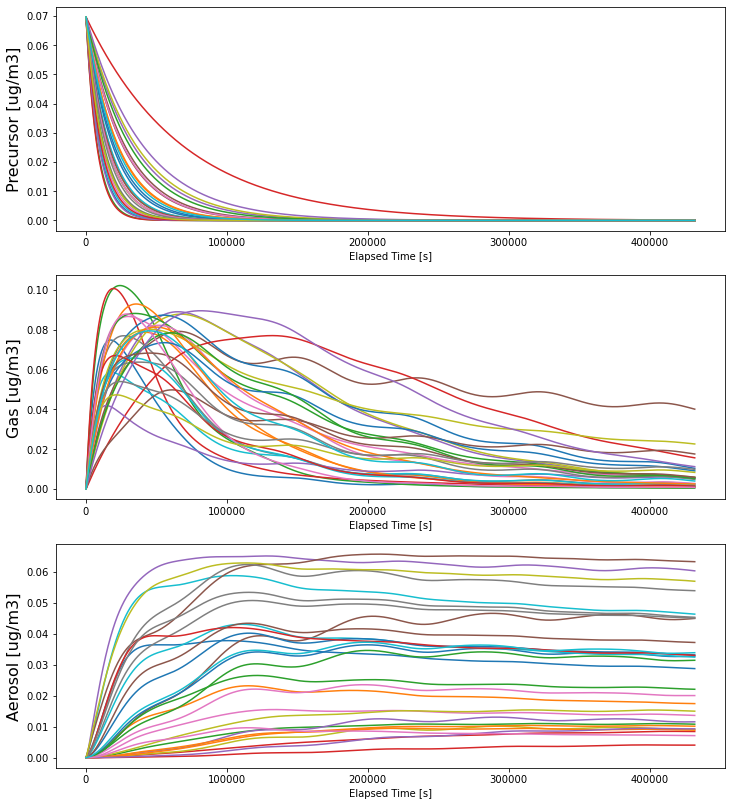

In [11]:
# Spaghetti plot random experiment timeseries (randomly choose 30 out of 1400 experiments)
num_experiments = 30
exps = sorted(random.sample(list(train['id'].unique()), num_experiments))
plot_df = train.loc[train['id'].isin(exps)].reset_index(drop=True)

fig, ax = plt.subplots(3,1, figsize=(12,14))
for i,lab in enumerate(['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug/m3]']):
    for exp in exps:
        ax[i].plot(plot_df[plot_df['id'] == exp].iloc[:,0], plot_df[plot_df['id'] == exp].iloc[:,i+1])
    ax[i].set_xlabel('Elapsed Time [s]')
    ax[i].set_ylabel(lab, fontsize=16) 

## Data Preperation
Here we prepare the data for machine learning by taking the respective variables from each column, offsetting the output data by 1 timestep (this is done inside the `prepare_data()` function, and scale. Make sure to not re-fit the scaler on the validation/test data and only `transform()` it. 

In [12]:
input_vars, output_vars = train.columns, train.columns[[0,1,2,3,-1]]
train_in, train_out = prepare_data(train, input_vars, output_vars)
val_in, val_out = prepare_data(val, input_vars, output_vars)

input_scaler = MinMaxScaler()
output_scaler = MinMaxScaler()

scaled_train_in = input_scaler.fit_transform(train_in.iloc[:,1:-1])
scaled_train_out = output_scaler.fit_transform(train_out.iloc[:,1:-1])
scaled_val_in = input_scaler.transform(val_in.iloc[:,1:-1])
scaled_val_out = output_scaler.transform(val_out.iloc[:,1:-1])

In [13]:
scaled_train_in.shape, scaled_train_out.shape, scaled_val_in.shape, scaled_val_out.shape,

((2015999, 9), (2015999, 3), (287999, 9), (287999, 3))

## Baseline Machine Learning Model
Here we use a pretty basic Dense Neural Network to predict the 3 output variables at the next timestep. We will then feed this into the Box Emulator model to run forward in time for n timesteps.

## Box Emulator Model
This model (`box_emulator()`), takes one timestep of initial conditions to feed the neural network we built. It then predicts one timestep, and uses the prediction as the input for another prediction (along with the static environmental variables), and so forth for *n* timesteps. In actual practice, the environmental variables from the climate model would be varying as well, but we use a variety of experiments with variable enviromental factors to learn from and simplify the process. 

The `run_emulator_ensemble()` function takes *n* random experiments and runs the `box_emulator()` for the length of each experiment and returns the predictions as well as the corresponding truth values.\

We can then use the `evaluate_box_mod()` to return a variety of performance metrics.

NOTE: It takes ~40 seconds per experiment to run the box emulator.

## Evaluation

As you can see, it is relatively easy to train the base network to predict t+1 values. It is far more challenging to model the length of the experiment (~1440 timesteps). Furthermore, you may discover that better performance on the neural network may not mean better performance with the box emulator. 

Some potential ideas for better emulator performance: adding some noise to the training data to prevent overfitting, or using a recurrent neural network/LSTM to utilize more than one timestep to inform prediction of the next. 

| Model Type | Metric | Variable |||
| ------------- | :----:|:-------:|:------:|:-----|
|  Baseline DNN|| Precursor | Gas | Aerosols |   
|              | RMSE: |**0.00019**|**0.00035**|**0.00014**|
|              | R2: |**0.99979**|**0.99984**|**0.99997**|
|              | Hellenger Distance: |**0.00002**|**0.00011**|**0.00004**|
|||||
|  Box Emulator|| Precursor | Gas | Aerosol |   
|              | RMSE: |**0.007**|**0.048**|**0.021**|
|              | R2: |**0.685**|**0.031**|**0.410**|
|              | Hellenger Distance: |**0.067**|**0.256**|**0.329**|

## Hackathon Challenges

### Monday

* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

#### Load the data

In [14]:
# data was loaded in default notebook

In [15]:
# view dimensions of data
train.shape, test.shape, val.shape

((2016000, 11), (288000, 11), (288000, 11))

#### Create an exploratory visualization of the data

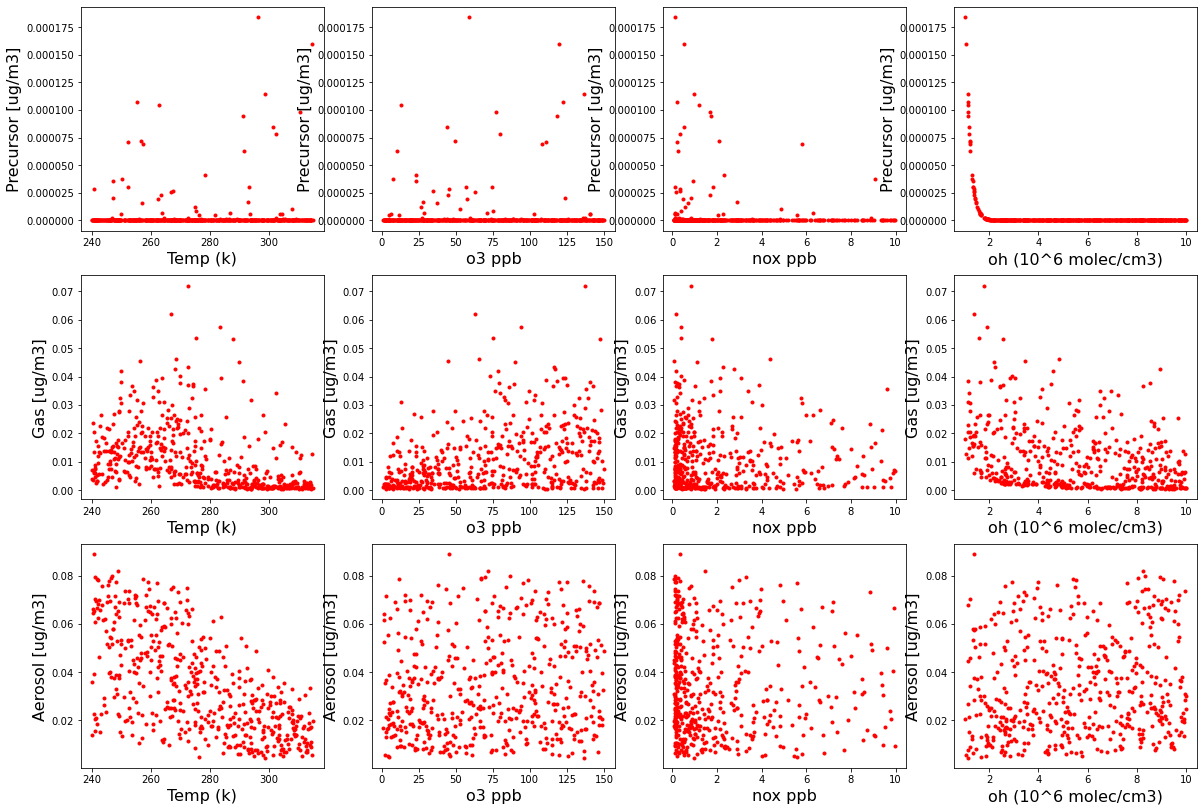

In [16]:
# scatter plots of pairs of variables
num_expiriments = 500
exps = sorted(random.sample(list(train['id'].unique()), num_expiriments))
plot_df = train.loc[train['id'].isin(exps)].reset_index(drop=True)
fig, ax = plt.subplots(3,4, figsize=(20,14))
for i,lab in enumerate(['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug/m3]']):
    for exp in exps:
        temp_df = plot_df[plot_df['id'] == exp]
        temp = temp_df['temperature (K)'].mean()
        SZA = temp_df['solar zenith angle (degree)'].mean()
        aer = temp_df['pre-existing aerosols (ug/m3)'].mean()
        o3 = temp_df['o3 (ppb)'].mean()
        nox = temp_df['nox (ppb)'].mean()
        oh = temp_df['oh (10^6 molec/cm3)'].mean()
        ax[i, 0].plot(temp, plot_df[plot_df['id'] == exp].iloc[-1,i+1], 'r.')
        ax[i, 0].set_ylabel(lab, fontsize=16)
        ax[i, 0].set_xlabel('Temp (k)', fontsize=16)
        ax[i, 1].plot(o3, plot_df[plot_df['id'] == exp].iloc[-1,i+1], 'r.')
        ax[i, 1].set_ylabel(lab, fontsize=16)
        ax[i, 1].set_xlabel('o3 ppb', fontsize=16)
        ax[i, 2].plot(nox, plot_df[plot_df['id'] == exp].iloc[-1,i+1], 'r.')
        ax[i, 2].set_ylabel(lab, fontsize=16)
        ax[i, 2].set_xlabel('nox ppb', fontsize=16)
        ax[i, 3].plot(oh, plot_df[plot_df['id'] == exp].iloc[-1,i+1], 'r.')
        ax[i, 3].set_ylabel(lab, fontsize=16)
        ax[i, 3].set_xlabel('oh (10^6 molec/cm3)', fontsize=16)

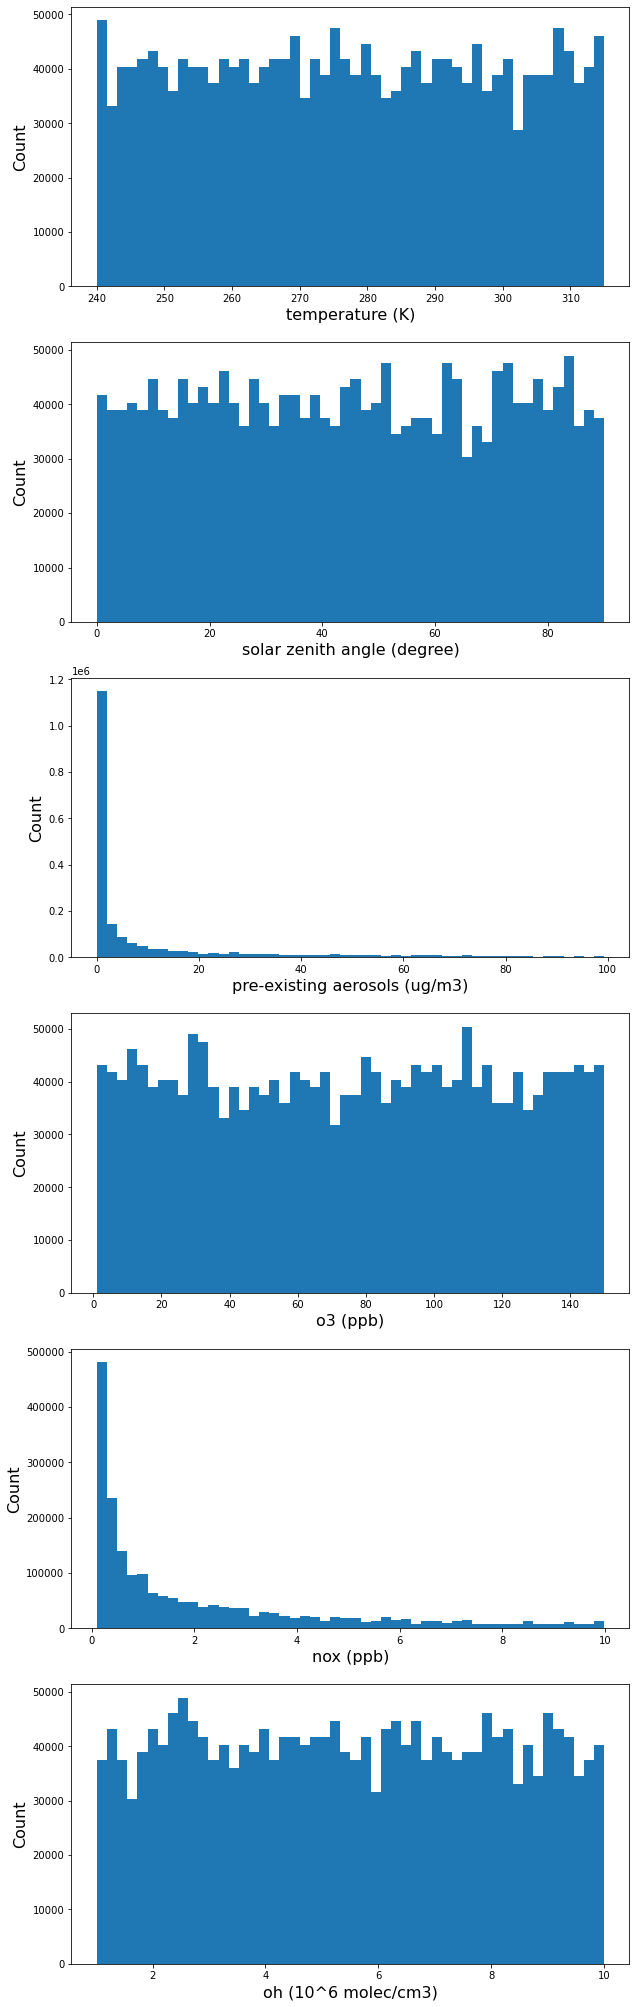

In [17]:
# plot histograms of potential input variables across all experiments and timepoints
inputs = ['temperature (K)', 'solar zenith angle (degree)',
          'pre-existing aerosols (ug/m3)', 'o3 (ppb)', 'nox (ppb)',
          'oh (10^6 molec/cm3)']
fig, ax = plt.subplots(6,1, figsize=(10,36))
for i,lab in enumerate(inputs):
    ax[i].hist(train[lab], bins=50)
    ax[i].set_xlabel(lab, fontsize=16)
    ax[i].set_ylabel('Count', fontsize=16)

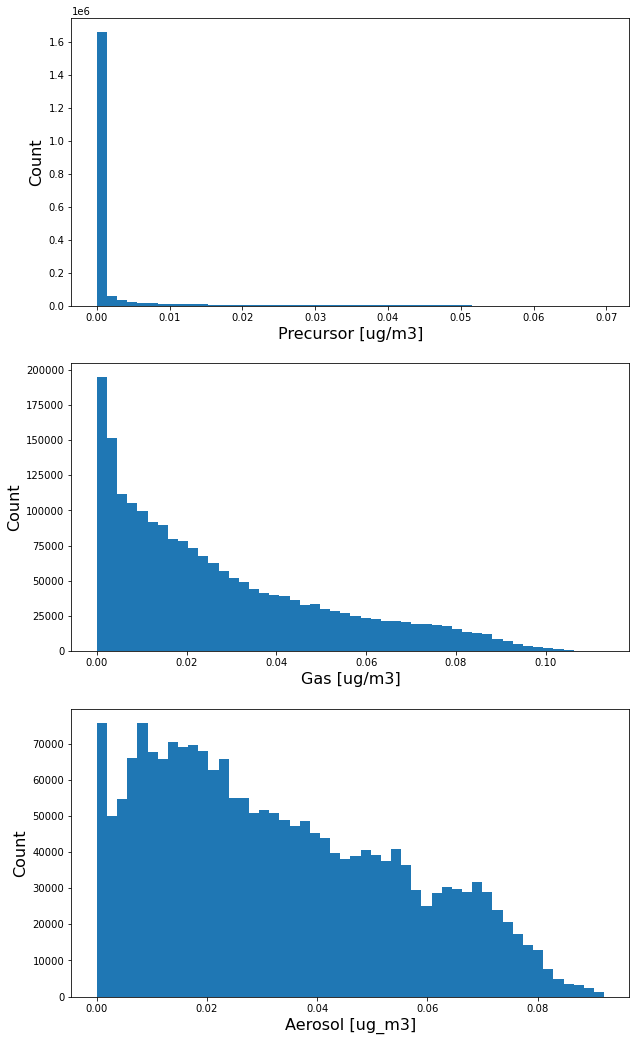

In [18]:
# plot histograms of potential output variables across all experiments and timepoints
outputs = ['Precursor [ug/m3]', 'Gas [ug/m3]', 'Aerosol [ug_m3]']
fig, ax = plt.subplots(3,1, figsize=(10,18))
for i,lab in enumerate(outputs):
    ax[i].hist(train[lab], bins=50)
    ax[i].set_xlabel(lab, fontsize=16)
    ax[i].set_ylabel('Count', fontsize=16)

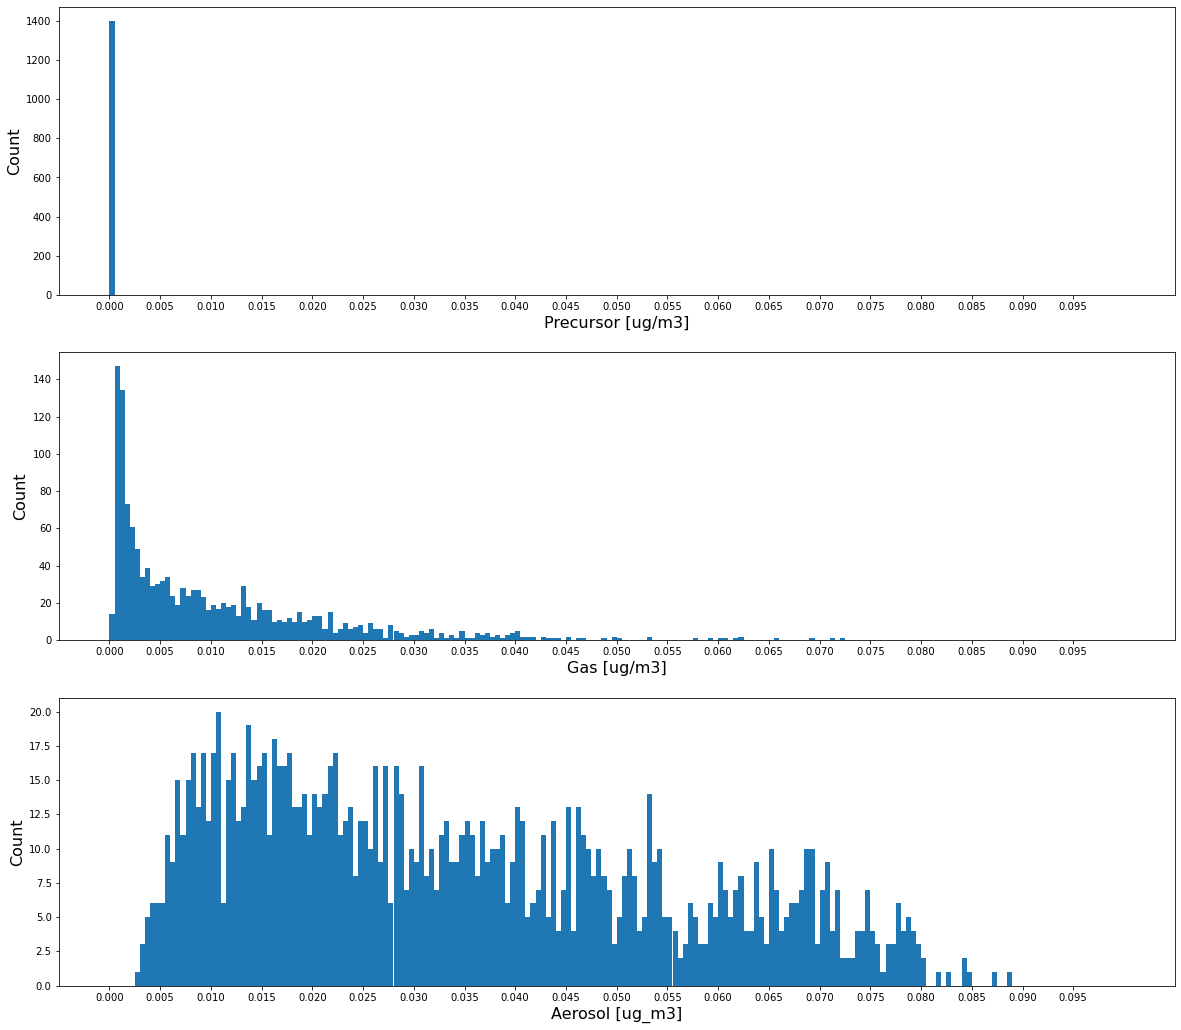

In [19]:
# plot distribution of final precursor-gas-aerosol split across all 1400 experiments
train_final = train[train['Time [s]'] == train['Time [s]'].max()]
fig, ax = plt.subplots(3,1, figsize=(20,18))
for i,lab in enumerate(outputs):
    ax[i].hist(train_final[lab], range=(0,0.1), bins=200)
    ax[i].set_xlabel(lab, fontsize=16)
    ax[i].set_ylabel('Count', fontsize=16)
    ax[i].set_xticks(np.arange(0,0.1,0.005))

In [20]:
# do all final points sum to the same value? no.
train_final[outputs].sum(axis=1)

indx
1439       0.054531
2879       0.043541
4319       0.044427
5759       0.008343
7199       0.009504
             ...   
2871359    0.008910
2872799    0.065813
2875679    0.007377
2878559    0.032819
2879999    0.058511
Length: 1400, dtype: float64

#### Test two different transformation and scaling methods

In [21]:
# transform Aerosol (ug/m3) to categorical encoding
train2 = train.copy(deep=True)
train2.loc[:, ('aerosol_category')] = ['low' if x < 0.011 else 'medium' if (x > 0.011 and x <0.056) else 'high' for x in train['Aerosol [ug_m3]']]

In [22]:
train2

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id,aerosol_category
indx,,,,,,,,,,,,
0,1.000000,6.967538e-02,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,low
1,301.207794,6.767269e-02,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,low
2,601.415588,6.572757e-02,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,low
3,901.623352,6.383835e-02,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,low
4,1201.831177,6.200343e-02,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,low
...,...,...,...,...,...,...,...,...,...,...,...,...
2879995,430799.156250,1.475598e-11,0.004754,0.053872,280.638099,23.939550,97.046059,89.326713,0.467903,3.914712,440,medium
2879996,431099.375000,1.452869e-11,0.004733,0.053864,280.638099,23.939550,97.046059,89.326713,0.467903,3.914712,440,medium
2879997,431399.593750,1.430491e-11,0.004712,0.053857,280.638099,23.939550,97.046059,89.326713,0.467903,3.914712,440,medium


In [23]:
# smoothing -- lowess smoothing of one experiment

In [24]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [25]:
train_1666 = train[train['id'] == 1666]

In [26]:
aerosol_lowess = lowess(endog=train_1666['Aerosol [ug_m3]'], exog=train_1666['Time [s]'])
train_1666.loc[:, ('aerosol_lowess')] = aerosol_lowess[:, 1]

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [27]:
train_1666

,Time [s],Precursor [ug/m3],Gas [ug/m3],Aerosol [ug_m3],temperature (K),solar zenith angle (degree),pre-existing aerosols (ug/m3),o3 (ppb),nox (ppb),oh (10^6 molec/cm3),id,aerosol_lowess
indx,,,,,,,,,,,,
0,1.000000,6.967538e-02,0.000000,0.000000,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.002340
1,301.207794,6.767269e-02,0.002783,0.000001,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.002380
2,601.415588,6.572757e-02,0.005749,0.000004,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.002419
3,901.623352,6.383835e-02,0.008627,0.000008,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.002458
4,1201.831177,6.200343e-02,0.011420,0.000013,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.002498
...,...,...,...,...,...,...,...,...,...,...,...,...
1435,430799.156250,4.648798e-20,0.026359,0.028318,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.028823
1436,431099.375000,4.515176e-20,0.026330,0.028310,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.028824
1437,431399.593750,4.385394e-20,0.026302,0.028302,264.135037,78.052738,0.022782,38.768707,0.206029,7.360145,1666,0.028825


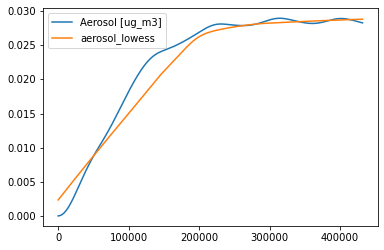

In [28]:
fig, ax = plt.subplots()
ax.plot(train_1666['Time [s]'], train_1666['Aerosol [ug_m3]'], label='Aerosol [ug_m3]')
ax.plot(train_1666['Time [s]'], train_1666['aerosol_lowess'], label='aerosol_lowess')
ax.legend();

#### Test one dimensionality reduction method

It was unclear to use how dimensionality reduction would be relevant to the GECKO dataset. We are used to using PCA, for example, when we have many output variables. Here we have only 3. David John seems to concur: "In the hackathon gecko dataset it is not really relevant unless you wanted to encode trends in time. ... PCA may be interesting to apply to the dataset from an analysis perspective to analyze how the data correlated with each other but is not necessary for this particular problem."

However, it might be useful to run PCA on the input variables, as several of them (o3, oh, solar zenith angle, and temperature) appear to be co-linear.

In [29]:
# principal component analysis -- not done

#### Train a linear model

In [30]:
# linear regression model

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [32]:
regressor = LinearRegression()  
regressor.fit(scaled_train_in, scaled_train_out) #training the algorithm
regressor.score(scaled_train_in, scaled_train_out)

0.9878809047093414

In [33]:
regressor.score(scaled_val_in, scaled_val_out)

0.9875372561556733

#### Train a decision tree ensemble method of your choice

In [35]:
# single decision tree
from sklearn.tree import DecisionTreeRegressor

In [36]:
dt = DecisionTreeRegressor(max_depth=2, random_state=0)
dt.fit(scaled_train_in[::10], scaled_train_out[::10])
dt.score(scaled_val_in, scaled_val_out)

0.5347934020420998

In [37]:
dt.score(scaled_val_in, scaled_val_out)

0.5347934020420998

In [39]:
# random forest
from sklearn.ensemble import RandomForestRegressor

In [40]:
clf = RandomForestRegressor(max_depth=2, random_state=0)
clf.fit(scaled_train_in[::10], scaled_train_out[::10])
clf.score(scaled_train_in[::10], scaled_train_out[::10])

0.5336762040488332

In [41]:
clf.score(scaled_val_in, scaled_val_out)

0.5370219537240687

### Tuesday

* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

#### Train a densely connected neural network

In [ ]:
# densely connected neural network with keras
import keras
from keras.models import Sequential
from keras.layers import Dense

In [58]:
# with loss='binary_crossentropy'
model=Sequential()
# Creating the input layer and first hidden layer
model.add(Dense(input_dim = 9, units = 10, activation='relu', kernel_initializer='uniform'))
# Create second hidden layer
model.add(Dense(units = 20, activation='relu', kernel_initializer='uniform'))
# Create output layer (units=number of output variable)
model.add(Dense(units = 3, activation='sigmoid', kernel_initializer='uniform'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(scaled_train_in,scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1) 

Epoch 1/5
7875/7875 [==============================] - 22s 3ms/step - loss: 0.3578 - accuracy: 0.9467 - val_loss: 0.3335 - val_accuracy: 0.9904
Epoch 2/5
7875/7875 [==============================] - 22s 3ms/step - loss: 0.3405 - accuracy: 0.9906 - val_loss: 0.3332 - val_accuracy: 0.9899
Epoch 3/5
7875/7875 [==============================] - 22s 3ms/step - loss: 0.3404 - accuracy: 0.9906 - val_loss: 0.3332 - val_accuracy: 0.9907
Epoch 4/5
7875/7875 [==============================] - 22s 3ms/step - loss: 0.3403 - accuracy: 0.9905 - val_loss: 0.3332 - val_accuracy: 0.9907
Epoch 5/5
7875/7875 [==============================] - 22s 3ms/step - loss: 0.3403 - accuracy: 0.9907 - val_loss: 0.3332 - val_accuracy: 0.9911


In [61]:
# with loss='mean_squared_error'
import keras
from keras.models import Sequential
from keras.layers import Dense
model=Sequential()
# Creating the input layer and first hidden layer
model.add(Dense(input_dim = 9, units = 10, activation='relu', kernel_initializer='uniform'))
# Create second hidden layer
model.add(Dense(units = 20, activation='relu', kernel_initializer='uniform'))
# Create output layer (units=number of output variable)
model.add(Dense(units = 3, activation='sigmoid', kernel_initializer='uniform'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.fit(scaled_train_in,scaled_train_out, validation_data=(scaled_val_in, scaled_val_out), 
                  batch_size=256, epochs=5, verbose=1)

Epoch 1/5
7875/7875 [==============================] - 21s 3ms/step - loss: 0.0046 - accuracy: 0.9584 - val_loss: 3.4789e-04 - val_accuracy: 0.9939
Epoch 2/5
7875/7875 [==============================] - 21s 3ms/step - loss: 3.4000e-04 - accuracy: 0.9937 - val_loss: 3.3901e-04 - val_accuracy: 0.9930
Epoch 3/5
7875/7875 [==============================] - 21s 3ms/step - loss: 3.3474e-04 - accuracy: 0.9934 - val_loss: 3.3353e-04 - val_accuracy: 0.9930
Epoch 4/5
7875/7875 [==============================] - 21s 3ms/step - loss: 3.3352e-04 - accuracy: 0.9936 - val_loss: 3.3260e-04 - val_accuracy: 0.9941
Epoch 5/5
7875/7875 [==============================] - 21s 3ms/step - loss: 3.3285e-04 - accuracy: 0.9936 - val_loss: 3.3072e-04 - val_accuracy: 0.9944


#### Train a convolutional or recurrent neural network (depends on problem)

In [70]:
# long short-term memory (LSTM)
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [71]:
def build_model(train_x, train_y):
    verbose, epochs, batch_size = 0, 25, 64
    n_timesteps, n_features, n_outputs = 1, train_x.shape[1], train_y.shape[1]
    train_x = np.reshape(train_x, (train_x.shape[0],1,train_x.shape[1]))
    print(train_x.shape)
    #train_y = np.reshape(train_y, (1, train_y.shape[0], train_y.shape[1]))
    print(n_timesteps, n_features, n_outputs)
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape = (n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu',return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [ ]:
model = build_model(scaled_train_in, scaled_train_out)

(2015999, 1, 9)
1 9 3


#### Experiment with different architectures

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
#Wednesday's code goes here


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them 

In [ ]:
#Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.